# Anomaly Detection

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.stats import multivariate_normal
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import euclidean_distances

from sklearn.cluster import KMeans

import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from tqdm.notebook import tqdm
import ipywidgets as widgets

## Exercise 2 -  Clustering-Based Anomaly Detection

Clustering-Based approaches detect outliers by examining the relationship between records and clusters

There exists three general approaches
1. Records not belonging to any cluster are outliers
1. **Records with a large distance to their closest cluster center are outliers**
1. All records in a small and sparse cluster are considered outliers

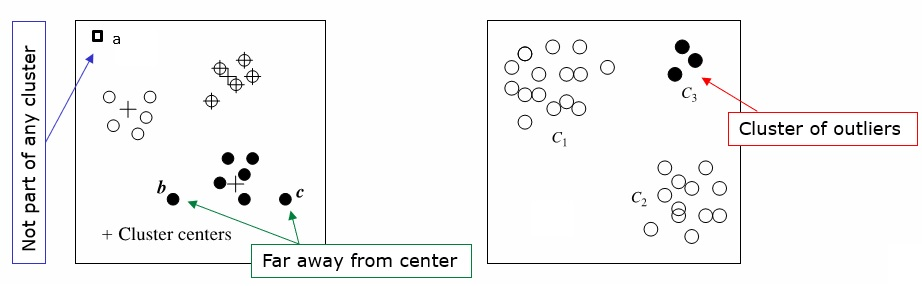

In this exercise **you should implement the second approach**.

### Prepare the dataset
We will prepare the creditcard dataset the same way as in the previous exercise.

In [ ]:
df = pd.read_csv('creditcard.csv')
features_to_drop = ['Time', 'V8', 'V13', 'V15', 'V20', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']
df.drop(columns=features_to_drop, inplace=True)

genuine = df[df.Class == 0]
anomalies = df[df.Class == 1]

genuine_X = genuine.drop(columns=["Class"]).values
genuine_y = genuine.Class.values

anomalies_X = anomalies.drop(columns=["Class"]).values
anomalies_y = anomalies.Class.values

X_train, X_test, y_train, y_test = train_test_split(genuine_X, genuine_y, test_size=0.4, random_state=42)

X_test = np.concatenate([X_test, anomalies_X])
y_test = np.concatenate([y_test, anomalies_y])

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("X_val:", X_val.shape)
print("Number of anomalies y_test:", y_test.sum())
print("Number of anomalies y_val:", y_val.sum())

#### Scale the data

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

### Generating cluster centers
To implement our anomaly detection algorithm we need to get the cluster centers. We will use the  [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) model with 50 clusters. As the seed value set `random_state=42`.

> Calculate the cluster centers from the training data

In [ ]:
# kmeans = ...
# cluster_centers = ...

*Click on the dots to display the solution*

In [ ]:

kmeans = KMeans(n_clusters=50, random_state=42)
kmeans.fit(X_train)

cluster_centers = kmeans.cluster_centers_

### Implement the prediction function
> Now that you have calculate the cluster centers you should implement the predict function to decide wether a point is an outlier or not. 
1. For each point calculate the distance to the nearest cluster center (use the euclidean distance as the distance function)
1. Mark all points as anomalies if their distance is larger than the given threshold

In [ ]:
def predict(X: np.ndarray, cluster_centers: np.ndarray, threshold: float) -> np.ndarray:
    # calculate the distance to the nearest cluster center
    # Mark points as anomalies if their distance is larger than the threshold
    pass

*Click on the dots to display the solution*

In [ ]:
def predict(X: np.ndarray, cluster_centers: np.ndarray, threshold: float) -> np.ndarray:
    distances = euclidean_distances(X, cluster_centers).min(axis=1)
    y_pred = distances > threshold
    return np.array(y_pred, dtype=int)

If your code is correct you should be able to run the following cell:

In [ ]:
threshold = 10
y_pred = predict(cluster_centers + threshold + 1, cluster_centers, threshold)
np.testing.assert_equal(np.ones((len(cluster_centers))), y_pred)

y_pred = predict(cluster_centers, cluster_centers, threshold)
np.testing.assert_equal(np.zeros((len(cluster_centers))), y_pred)

### Tune `threshold` hyperparameter
As you have noticed our model contains is using a `threshold` hyperparameter. Let's tune it using our validation set.

#### Manually tune the threshold
You can play around with the slider to get the best threshold

In [ ]:
@widgets.interact(thresh =(0,20,0.1))
def f(thresh=1):
    y_pred = predict(X_val, cluster_centers, thresh)
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred, average="binary")
    
    print("Detected number of outliers:", y_pred.sum())
    print("Actual number of outliers:", y_val.sum())
    print("------")
    print("Precision:", precision)
    print("Recall", recall)
    print("F1", f1)

#### Tune the paramter by using a grid search

In [ ]:
f1_scores = []
precision_scores = []
recall_scores = []
thresholds = np.linspace(0, 20, 200)
for thresh in tqdm(thresholds):
    y_pred = predict(X_val, cluster_centers, thresh)
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred, average="binary")
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)
    
best_thresh = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)
print("Best threshold {} with f1 score {}".format(best_thresh, best_f1))

#### Visualize the relationship between the metrics and the threshold

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(thresholds, f1_scores, label="f1")
ax.plot(thresholds, precision_scores, label="precision")
ax.plot(thresholds, recall_scores, label="recall")
ax.plot(best_thresh, best_f1, marker="o")
ax.set_xlabel("Threshold")
ax.set_ylabel("Score")
ax.legend()

### Evaluate on the test set
Now that we have tuned our `threshold` hyperparameter we can calculate the metrics on the test set.

In [ ]:
y_pred = predict(X_test, cluster_centers, best_thresh)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")

print("Detected number of outliers:", y_pred.sum())
print("Actual number of outliers:", y_test.sum())
print("------")
print("Precision:", precision)
print("Recall", recall)
print("F1", f1)

In [ ]:
def plot_confusion_matrix(cm):
    fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
    sns.heatmap(cm, 
                xticklabels=['Genuine', 'Fraud'],
                yticklabels=['Genuine', 'Fraud'],
                annot=True,ax=ax1,
                linewidths=.2,linecolor="Darkblue", cmap="Blues")
    plt.title('Confusion Matrix', fontsize=14)
    plt.show()

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

# Check your results on ILIAS
On ILIAS you will find a online quiz where you can check your results.

> Submit the value of your tuned `threshold` for which you received a f1-score of minimum **70%** on the validation set.